In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM

We based this code on the output of the other notebook inside the repos (DataCentric.ipynb). We will use the same preprocessing steps here, but we will try to create additional data. The competition limits the data to 3500 samples, and the outlier removal create room for new data. 

In [2]:
# Local path
data_path = 'data/sample_submission.csv'
# Kaggle path
# data_path = '/kaggle/input/playground-series-s3e21/sample_submission.csv'

In [3]:
submission_df = pd.read_csv(data_path)
num_feature = submission_df.columns.drop(['id', 'target'])
target = 'target'
submission_df.target = submission_df.target.clip(7,20)

# SGD
clf = SGDOneClassSVM(nu=0.55).fit(submission_df[num_feature])
outlier_indices = clf.predict(submission_df[num_feature]) == -1
submission_df = submission_df.iloc[~outlier_indices]

# IsolationForest
lf = IsolationForest(random_state=0).fit(submission_df[num_feature])
outlier_indices = clf.predict(submission_df[num_feature]) == -1
submission_df = submission_df.iloc[~outlier_indices]

# LOF
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_indices = lof.fit_predict(submission_df[num_feature]) == -1
submission_df = submission_df.iloc[~outlier_indices]

lowest_quality_labels =  [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]
submission_df = submission_df.iloc[~submission_df.index.isin(lowest_quality_labels)]

submission_df = submission_df[submission_df.target != 7]

col_to_keep = ['O2_1', 'O2_2', 'BOD5_5', 'target']

for i in submission_df.columns:
    if i not in col_to_keep:
        submission_df[i]=0

In [4]:
submission_df.describe()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,2945.0,2945.000000,2945.000000,2945.000000,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,...,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.000000,2945.0,2945.0
mean,0.0,8.556978,8.310078,9.204682,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.703842,0.0,0.0
std,0.0,1.286640,3.012390,6.440485,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.265058,0.0,0.0
min,0.0,7.010000,1.490000,2.200000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.020000,0.0,0.0
25%,0.0,7.490000,7.170000,7.400000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.725000,0.0,0.0
50%,0.0,8.390000,7.933000,8.300000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.370000,0.0,0.0
75%,0.0,9.110000,9.100000,8.700000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.400000,0.0,0.0
max,0.0,20.000000,46.950000,45.900000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.725000,0.0,0.0


In [5]:
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.decomposition import PCA

In [6]:
# Create a custom dataset to load the data during training
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

# Create the dataset with only the important feature. We will lose some information but it will
# help in the training process.
col_to_keep = ['O2_1', 'O2_2', 'BOD5_5', 'target']
training_ds = CustomDataset(submission_df[col_to_keep])

# Convert CustomDataset to a numpy matrix
training_data_matrix = np.array([sample.astype(np.float32) for sample in training_ds])

# Initialize the scaler, fit on the data and transform
scaler = StandardScaler()
normalized_data_matrix = scaler.fit_transform(training_data_matrix)

# Convert back to CustomDataset
normalized_df = pd.DataFrame(normalized_data_matrix, columns=col_to_keep)
normalized_training_ds = CustomDataset(normalized_df)

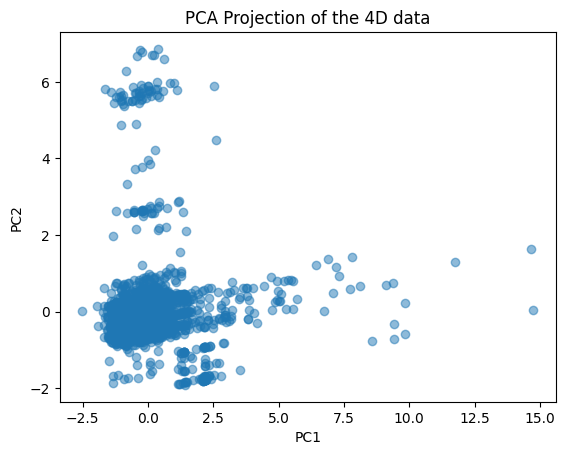

In [7]:
# Make a PCA on the normalized_df to display the 4 dimensions in 2D

pca = PCA(n_components=2)
pca.fit(normalized_df)
pca_samples = pca.transform(normalized_df)

# Plot the 2D projection of the 4D data
plt.scatter(pca_samples[:, 0], pca_samples[:, 1], alpha=0.5)
plt.title("PCA Projection of the 4D data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

First, we will try with an autoencoder

In [8]:
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
class AutoEncoder(T.nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),

            nn.Linear(10, 10),
            nn.ReLU(),

            nn.Linear(10, encoding_dim),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 10),
            nn.ReLU(),

            nn.Linear(10, 10),
            nn.ReLU(),

            nn.Linear(10, input_dim),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# Define the model
autoencoder = AutoEncoder(input_dim=4, encoding_dim=3).to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)  # Reduce LR every 30 epochs by 70%

In [10]:
# Define the training function
def train(model, dataset, num_epochs=50, batch_size=32):
    dataloader = T.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss_values = []
    
    best_loss = np.inf
    best_model = None

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for data in dataloader:
            data = data.to(device)  # Send data to GPU
            outputs = model(data)
            loss = loss_function(outputs, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        scheduler.step()  
        average_epoch_loss = epoch_loss / len(dataloader)

        if average_epoch_loss < best_loss:
            best_loss = average_epoch_loss
            best_model = model.state_dict()
        
        loss_values.append(average_epoch_loss)
        print(f'\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Best: {best_loss:.4f}', end='')


    model.load_state_dict(best_model)
    # Plotting
    plt.plot(loss_values)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

Epoch 500/500, Loss: 0.2092, Best: 0.2092

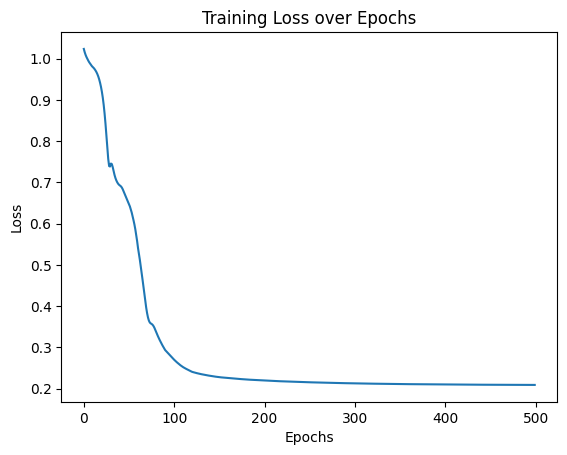

In [11]:
train(autoencoder, normalized_training_ds, num_epochs=500, batch_size=2983)
# train(autoencoder, training_ds, num_epochs=500, batch_size=2983)

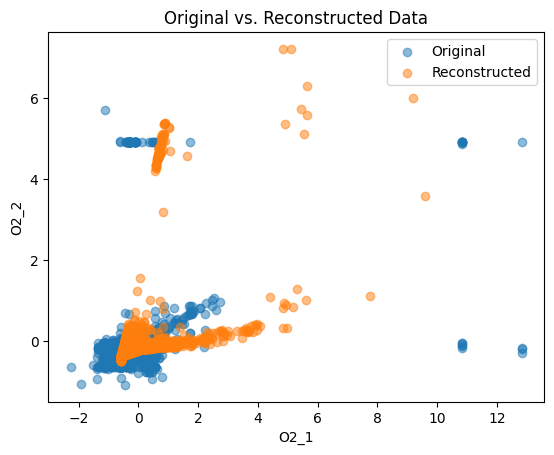

In [12]:
# Pass the original data through the autoencoder and visualize the results
dataloader_eval = T.utils.data.DataLoader(normalized_training_ds, batch_size=len(normalized_training_ds), shuffle=False)

reconstructed_data = []
autoencoder.eval()
# Visualize the results
with T.no_grad():
    for data in dataloader_eval:
        outputs = autoencoder(data)
        reconstructed_data.append(outputs)
        
    reconstructed_data = T.cat(reconstructed_data).numpy()
    plt.scatter(normalized_df.iloc[:, 0], normalized_df.iloc[:, 1], alpha=0.5, label='Original')
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.5, label='Reconstructed')
    plt.title("Original vs. Reconstructed Data")
    plt.xlabel("O2_1")
    plt.ylabel("O2_2")
    plt.legend()
    plt.show()

c:\Users\Thiba\Documents\GitHub\playground-series-s3e21\.venv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


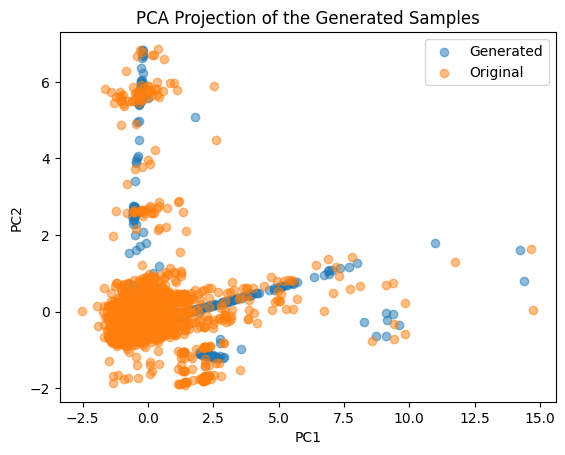

In [13]:
# With the same PCA, project the generated samples
pca_generated_samples = pca.transform(reconstructed_data)

# Plot the 2D projection of the generated samples
plt.scatter(pca_generated_samples[:, 0], pca_generated_samples[:, 1], alpha=0.5, label='Generated')
plt.scatter(pca_samples[:, 0], pca_samples[:, 1], alpha=0.5, label='Original')
plt.title("PCA Projection of the Generated Samples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

Epoch 1000/1000, Loss: 3647.4832, Best: 3594.6719

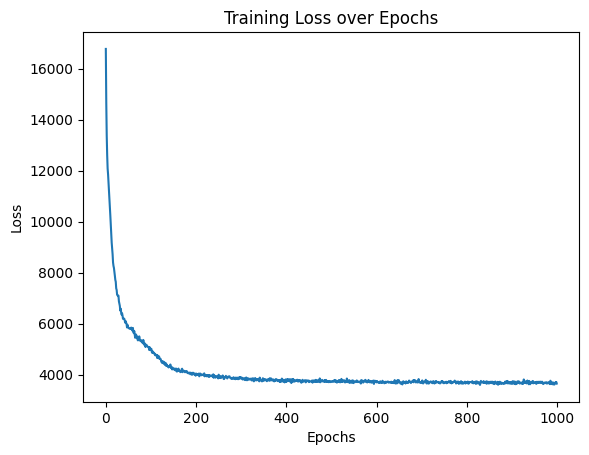

In [14]:
L = 25  # Adjust this based on your VAE architecture's latent space size

class VAE(nn.Module):
    def __init__(self, input_dim=4):
        self.input_dim = input_dim
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(self.input_dim, 25)
        self.fc2_mu = nn.Linear(25, L)
        self.fc2_logvar = nn.Linear(25, L)

        # Decoder
        self.fc3 = nn.Linear(L, 25)
        self.fc4 = nn.Linear(25, self.input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = T.exp(0.5*logvar)
        eps = T.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss function
def loss_function(recon_x, x, mu, logvar, beta=0.5):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * T.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD



# Training
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 1000
beta = 0.5
dataloader = T.utils.data.DataLoader(normalized_training_ds, batch_size=2983, shuffle=True)
# dataloader = T.utils.data.DataLoader(training_ds, batch_size=2983, shuffle=True)
best_loss = np.inf
best_model = None
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in dataloader:
        data = data.to(device)
        model.train()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss = loss_function(recon_batch, data, mu, log_var, beta=beta)
        loss.backward()
        optimizer.step()

        epoch_loss = loss.item()

    average_epoch_loss = epoch_loss / len(dataloader)
    if average_epoch_loss < best_loss:
            best_loss = average_epoch_loss
            best_model = model.state_dict()

    loss_values.append(average_epoch_loss)
    print(f'\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Best: {best_loss:.4f}', end='')

model.load_state_dict(best_model)
# Plotting
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

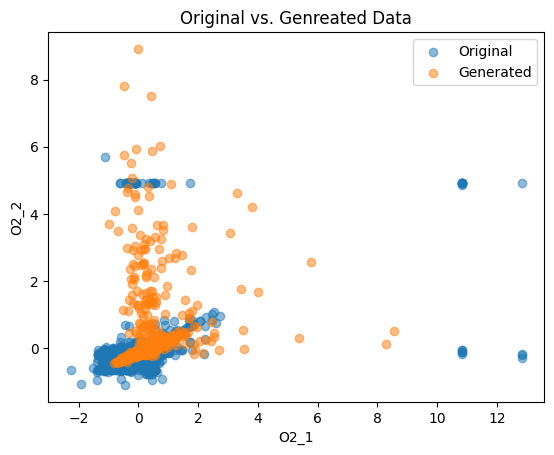

In [15]:
model.eval()
with T.no_grad():
    # Sample from a standard normal distribution
    z = T.randn(3500, L).to(device)
    generated_samples = model.decode(z).cpu().numpy()

    
original_samples = data[:].numpy()

plt.scatter(normalized_df.iloc[:, 0], normalized_df.iloc[:, 1], alpha=0.5, label='Original')
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label='Generated')
plt.title("Original vs. Genreated Data")
plt.xlabel("O2_1")
plt.ylabel("O2_2")
plt.legend()
plt.show()


c:\Users\Thiba\Documents\GitHub\playground-series-s3e21\.venv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


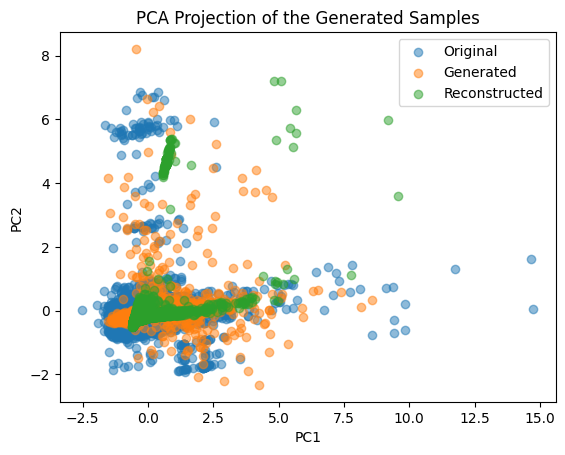

In [16]:
# With the same PCA, project the generated samples
pca_generated_samples = pca.transform(generated_samples)

# Plot the 2D projection of the generated samples, the reconstructed data and the original data
plt.scatter(pca_samples[:, 0], pca_samples[:, 1], alpha=0.5, label='Original')
plt.scatter(pca_generated_samples[:, 0], pca_generated_samples[:, 1], alpha=0.5, label='Generated')
plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.5, label='Reconstructed')
plt.title("PCA Projection of the Generated Samples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


Use the same function as the one used in the exploration to evaluate each dataset

In [17]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
# Create a dataframe that will contain the score of each methods
kfold_results = pd.DataFrame(columns=['Description', 'MSE', 'MAE'])

# Function that will train a model with a kfold based on the dataset in parameter and will
# calculate the mean squared error and the mean absolute error. 
def kfold_train_model(df: pd.DataFrame, description: str, features: list, fold: int = 5):
    global kfold_results
    X = df[features]
    y = df[target]
    rf = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42)
    
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)

    mse_scores = []
    mae_scores = []

    for train_index, test_index in kf.split(X):
        # Split data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        rf.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = rf.predict(X_test)
        
        # Calculate Mean Squared Error for this fold
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

        # Calculate Mean Absolute Error for this fold
        mae = mean_absolute_error(y_test, y_pred)
        mae_scores.append(mae)
    
    # Calculate the mean of the scores
    mse_mean = np.mean(mse_scores)
    mae_mean = np.mean(mae_scores)

    # Append the scores to the dataframe
    kfold_results = pd.concat([kfold_results, pd.DataFrame({'Description': description, 'MSE': mse_mean, 'MAE': mae_mean}, index=[0])], ignore_index=True)


In [19]:
# Recreate a dataframe from the generated samples, with the same column as the original dataframe
generated_df = pd.DataFrame(generated_samples, columns=['O2_1', 'O2_2', 'BOD5_5', 'target'])
reconstructed_df = pd.DataFrame(reconstructed_data, columns=['O2_1', 'O2_2', 'BOD5_5', 'target'])

# Convert the DataFrame to numpy array
generated_data_matrix = generated_df.values
reconstructed_data_matrix = reconstructed_df.values

# Use inverse_transform to get the original scale data
inverse_generated_data = scaler.inverse_transform(generated_data_matrix)
inverse_reconstructed_data = scaler.inverse_transform(reconstructed_data_matrix)

# Convert back to DataFrame if needed
generated_df = pd.DataFrame(inverse_generated_data, columns=generated_df.columns)
reconstructed_df = pd.DataFrame(inverse_reconstructed_data, columns=reconstructed_df.columns)

# Reorder the column to match the original dataframe
column_order = submission_df.columns
generated_df = generated_df.reindex(columns=column_order)
reconstructed_df = reconstructed_df.reindex(columns=column_order)

generated_df = generated_df.fillna(0)
reconstructed_df = reconstructed_df.fillna(0)

The goal here isn't to replace all the data with new data, but to complete the data we have with new data. To choose which data to add, 
we will calculate the rmse of each point and select only the worst ones. The worst ones should improve the model the most.

In [20]:
from sklearn.model_selection import cross_val_predict
from collections import OrderedDict

def compute_rmse_contributions(X, y, n_estimators=25, max_depth=7, random_state=42):
    """
    Compute the RMSE contribution for each data point using cross-validation.
    """

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    # Calculate RMSE for each data point using cross-validation
    predicted_y = cross_val_predict(model, X, y, cv=5)  # You can adjust cv as needed

    # Calculate RMSE for each data point
    rmse_contributions = []
    rmse=[]
    for i in range(len(X)):
        y_true_i = y.iloc[i] if isinstance(y, pd.Series) else y[i]
        y_pred_i = predicted_y[i]
        rmse_i = np.sqrt(mean_squared_error([y_true_i], [y_pred_i]))
        rmse_contributions.append((i, rmse_i))
        rmse.append(rmse_i)
    print(np.mean(rmse))

    # Sort RMSE contributions in decreasing order
    sorted_rmse_contributions = OrderedDict(sorted(rmse_contributions, key=lambda x: x[1], reverse=True))

    return sorted_rmse_contributions

In [21]:
X = submission_df.drop(columns=['target'])
y = submission_df['target']

sorted_rmse_contributions = compute_rmse_contributions(X, y)

0.6676586232889914


In [22]:
X = generated_df.drop(columns=['target'])
y = generated_df['target']

sorted_rmse_contributions_generated = compute_rmse_contributions(X, y)

0.07297066904633054


In [23]:
X = reconstructed_df.drop(columns=['target'])
y = reconstructed_df['target']

sorted_rmse_contributions_reconstructed = compute_rmse_contributions(X, y)

0.022708873291608266


In [24]:
to_reinject = 3500-submission_df.shape[0]

In [25]:
worst_indexes_generated = list(sorted_rmse_contributions.keys())[:to_reinject]
worst_indexes_reconstructed = list(sorted_rmse_contributions.keys())[:to_reinject]

In [26]:
# Train the model with the original dataset
kfold_train_model(df=submission_df.drop(columns=['id'], axis=1), features=num_feature, description='submission')

C:\Users\Thiba\AppData\Local\Temp\ipykernel_57128\2783633359.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_results = pd.concat([kfold_results, pd.DataFrame({'Description': description, 'MSE': mse_mean, 'MAE': mae_mean}, index=[0])], ignore_index=True)


In [27]:
kfold_results.sort_values(by='MAE')

,Description,MSE,MAE
0,submission,0.868763,0.662247


In [28]:
# Reset the index in the orinal dataframe
submission_df = submission_df.reset_index(drop=True)

In [29]:
generated_sample_to_add = generated_df.iloc[worst_indexes_generated]
reconstructed_to_add = reconstructed_df.iloc[worst_indexes_reconstructed]

generated_sample_to_add = generated_sample_to_add.reset_index(drop=True)
reconstructed_to_add = reconstructed_to_add.reset_index(drop=True)


submission_generated_df = pd.concat([submission_df, generated_sample_to_add], ignore_index=True)
submission_reconstructed_df = pd.concat([submission_df, reconstructed_to_add], ignore_index=True)


In [30]:
# Train the model with the original dataset
kfold_train_model(df=submission_generated_df.drop(columns=['id'], axis=1), features=num_feature, description='With generated samples')
kfold_train_model(df=submission_reconstructed_df.drop(columns=['id'], axis=1), features=num_feature, description='With reconstructed samples')

In [31]:
kfold_results.sort_values(by='MAE')

,Description,MSE,MAE
2,With reconstructed samples,0.816556,0.594680
1,With generated samples,0.813245,0.603088
0,submission,0.868763,0.662247


The usage of generated data with the VAE and with the auto-encoder seems to help the model. The results with the VAE are better so we will use it.

In [32]:
submission_generated_df.shape

(3500, 37)

In [33]:
submission_generated_df.to_csv('submission.csv', index=False)